# Carga de datos

In [1]:
import pandas as pd


clients = pd.read_csv("datos/caso_3/clients.csv")
depots = pd.read_csv("datos/caso_3/depots.csv")
depots = depots.drop(columns=["DepotID"])
vehicles = pd.read_csv("datos/caso_3/vehicles.csv")


print(clients.head())
print(depots.head())
print(vehicles.head())

   LocationID  ClientID   Latitude  Longitude  Demand   TimeWindow
0           2         1  12.341057 -71.723837    25.0  13:05-14:05
1           3         2  12.310993 -71.719252     9.0  13:15-14:15
2           4         3  12.326781 -71.668190    18.0  10:00-10:60
3           5         4  12.330562 -71.694530    22.0  12:45-13:45
4           6         5  12.346781 -71.708920    13.0  14:35-15:35
   LocationID  Latitude  Longitude
0           1  12.31846 -71.716203
   VehicleID   Type  Capacity  Range  Speed
0          1    4x4     200.0  804.0    NaN
1          2  drone      25.0  480.0  135.0
2          3  drone      25.0  480.0  135.0


# Aux

In [2]:
from haversine import haversine

def haversine_distance(coord1, coord2):
    """
    Calculate the haversine distance between two coordinates.
    :param coord1: Tuple of (latitude, longitude) for the first coordinate.
    :param coord2: Tuple of (latitude, longitude) for the second coordinate.
    :return: Distance in kilometers.
    """
    return haversine(coord1, coord2)

In [3]:
depots = depots.rename(columns={"LocationID": "id"})
# Leer el depósito original y replicarlo
original_depot = depots.iloc[0]
depot_replications = 6
depot_list = []

for i in range(depot_replications):
    depot_list.append({
        "id": i,
        "Longitude": original_depot["Longitude"],
        "Latitude": original_depot["Latitude"],
        "Demand": 0
    })

depots_df = pd.DataFrame(depot_list)

clients = clients.rename(columns={"LocationID": "id"})
clients = clients.reset_index(drop=True)
clients["id"] = clients.index + depot_replications

depots["id"] = 0 
depots["Demand"] = 0

depots = depots[["id", "Longitude", "Latitude", "Demand"]]
clients = clients[["id", "Longitude", "Latitude", "Demand"]]

nodes = pd.concat([depots_df, clients], ignore_index=True)

N = nodes["id"].tolist()
V = vehicles["VehicleID"].tolist()
De = nodes.set_index("id")["Demand"].to_dict()
C = clients["id"].tolist()
D = depots_df["id"].tolist()

lat_lon_list = [tuple(coord) for coord in nodes[["Latitude", "Longitude"]].values.tolist()] # lista de tuplas con latitudes y longitudes ordenadas por id
lon_lat_list = [(lon, lat) for lat, lon in lat_lon_list] # lista de tuplas con longitudes y latitudes ordenadas por id

di_haversine = [
    [10000 if i == j or (0 <= i <= 5 and 0 <= j <= 5) else haversine_distance(lat_lon_list[i], lat_lon_list[j])
     for i in range(len(lat_lon_list))]
    for j in range(len(lat_lon_list))
]


# la otra distancia se calcula con offset 30% más que el haversine

di_street = [
    [d * 1.3 for d in fila] for fila in di_haversine
]

di = [di_street, di_haversine] # matriz de distancias entre nodos, primero carro y luego dron

costos = [0.57, 0.233] # costo por km carro y dron
tipo = [0 if i == "4x4" else 1 for i in vehicles["Type"].tolist()]

depot = 0

P = vehicles.set_index("VehicleID")["Capacity"].to_dict()
M = vehicles.set_index("VehicleID")["Range"].to_dict()

print("Nodos:", N)
print("Clientes:", C)
print("Vehículos:", V)
print("Capacidades:", P)
print("Alcances:", M)
print("Demanda:", De)
print("latlon", lat_lon_list)
print("Distancias haversine:", di_haversine)
print("Costos:", costos)
print("Tipo de vehículo:", tipo)

import pandas as pd

# Crear una tabla con las distancias desde cada nodo hacia los depósitos replicados (0 a 5)
dist_check_df = pd.DataFrame(columns=[f'Dist_a_depot_{d}' for d in range(6)], index=N)

for i in N:
    for d in range(6):
        dist_check_df.loc[i, f'Dist_a_depot_{d}'] = di_haversine[i][d]

# Convertir a float para formato
dist_check_df = dist_check_df.astype(float)

# Mostrar solo las filas que corresponden a clientes (u opcionalmente todos los nodos)
print("\nDistancias desde cada nodo hacia los 6 depósitos replicados (Haversine):")
print(dist_check_df.loc[C].to_string(float_format='%.3f'))  # muestra primeras 15 filas con 3 decimales



Nodos: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Clientes: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Vehículos: [1, 2, 3]
Capacidades: {1: 200.0, 2: 25.0, 3: 25.0}
Alcances: {1: 804.0, 2: 480.0, 3: 480.0}
Demanda: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 25.0, 7: 9.0, 8: 18.0, 9: 22.0, 10: 13.0, 11: 4.0, 12: 5.0, 13: 10.0, 14: 9.0, 15: 9.0, 16: 10.0, 17: 24.0, 18: 12.0, 19: 15.0, 20: 30.0, 21: 34.0, 22: 32.0}
latlon [(12.318460239849047, -71.71620272777695), (12.318460239849047, -71.71620272777695), (12.318460239849047, -71.71620272777695), (12.318460239849047, -71.71620272777695), (12.318460239849047, -71.71620272777695), (12.318460239849047, -71.71620272777695), (12.341057283841172, -71.72383742283766), (12.31099305645978, -71.71925230381949), (12.32678082553054, -71.66818980959306), (12.330562, -71.69453), (12.346781, -71.70892), (12.315673, -71.74231), (12.298345, -71.72056), (12.322089, -71.68234), (12.3056

# Modelo

In [4]:
from pyomo.environ import *

model = ConcreteModel()

# Datos
model.N = Set(initialize=N)                # Todos los nodos
model.C = Set(initialize=C)                # Clientes
model.V = Set(initialize=V)                # Vehículos
model.D = Set(initialize=D)                # Depósitos
model.depot = Param(initialize=depot)

def tipo_init(model, k):
    return tipo[k - 1]

model.tipo = Param(model.V, initialize=tipo_init, within=Binary)

# Distancias por tipo de transporte (0: 4x4, 1: dron)
def dist_init(model, i, j, k):
    tipo_k = model.tipo[k]
    return di[tipo_k][i][j]
model.d = Param(model.N, model.N, model.V, initialize=dist_init, within=NonNegativeReals)

# Demanda, capacidad y máximo recorrido
model.De = Param(model.N, initialize=De, within=NonNegativeReals, default=0)
model.P = Param(model.V, initialize=P, within=NonNegativeReals)
model.M = Param(model.V, initialize=M, within=NonNegativeReals)

# Costos por tipo de vehículo
def cost_init(model, i, j, k):
    if i == j:
        return 0
    tipo_k = model.tipo[k]
    return di[tipo_k][i][j] * costos[tipo_k]
model.cost = Param(model.N, model.N, model.V, initialize=cost_init, within=NonNegativeReals, default=0)



# Variables
model.x = Var(model.N, model.N, model.V, domain=Binary)
model.u = Var(model.N, model.V, within=NonNegativeIntegers, bounds=(1, len(N)))
model.ve = Var(model.V, domain=Binary)
model.W = Var(model.N, model.V, within=NonNegativeReals, bounds=(0, max(P.values())))


# Función objetivo: minimizar costo total
model.obj = Objective(
    expr=sum(model.cost[i, j, k] * model.x[i, j, k] for k in model.V for i in model.N for j in model.N if i != j),
    sense=minimize
)

# Restricciones
model.visit_once = ConstraintList()
for i in model.C:
    model.visit_once.add(sum(model.x[i, j, k] for j in model.N for k in model.V if i != j) == 1)


model.flows = ConstraintList()
for k in model.V:
    model.flows.add(sum(model.x[d, j, k] for d in model.D for j in model.N if j != d) <= 6)
    model.flows.add(sum(model.x[j, d, k] for d in model.D for j in model.N if j != d) <= 6)


# model.start_node = ConstraintList()
# for k in model.V:
#     model.start_node.add(sum(model.x[model.depot, j, k] for j in model.N if j != model.depot) == model.ve[k])

# model.end_node = ConstraintList()
# for k in model.V:
#     model.end_node.add(sum(model.x[j, model.depot, k] for j in model.N if j != model.depot) == model.ve[k])

model.flow = ConstraintList()
for k in model.V:
    for i in model.C:
        model.flow.add(
            sum(model.x[i, j, k] for j in model.N if i != j) ==
            sum(model.x[j, i, k] for j in model.N if i != j)
        )

model.mtz = ConstraintList()
for k in model.V:
    for i in model.C:
        for j in model.C:
            if i != j:
                model.mtz.add(model.u[i, k] - model.u[j, k] + len(N) * model.x[i, j, k] <= len(N) - 1)

# model.Carga = ConstraintList()
# for k in model.V:
#     expr = sum(model.x[i, j, k] * model.De[j] for i in model.N for j in model.N if i != j)
#     model.Carga.add(expr <= model.P[k])

# model.Distancia = ConstraintList()
# for k in model.V:
#     expr = sum(model.x[i, j, k] * model.d[i, j, k] for i in model.N for j in model.N if i != j)
#     model.Distancia.add(expr <= model.M[k])
    
model.update_carga = ConstraintList()
for k in model.V:
    for i in model.N:
        for j in model.N:
            if i != j:
                if j in C:
                    model.update_carga.add(
                        model.W[j, k] <= model.W[i, k] - model.De[j] + (1 - model.x[i, j, k]) * 100000
                    )
                    model.update_carga.add(
                        model.W[j, k] >= model.W[i, k] - model.De[j] - (1 - model.x[i, j, k]) * 100000
                    )
                elif j in D:
                    model.update_carga.add(
                        model.W[j, k] <= model.P[k] + (1 - model.x[i, j, k]) * max(P.values())
                        
                    )
                    model.update_carga.add(
                        model.W[j, k] >= model.P[k] - (1 - model.x[i, j, k]) * max(P.values())
                        
                    )


model.demanda_una_vez = ConstraintList()
for j in model.C:
    model.demanda_una_vez.add(
        sum(model.x[i, j, k] for k in model.V for i in model.N if i != j) == 1
    )

        
        
model.entrega_con_carga = ConstraintList()
for k in model.V:
    for i in model.N:
        for j in model.C:
            if i != j:
                model.entrega_con_carga.add(
                    model.W[j, k] >= model.x[i, j, k] * model.De[j]
                )

model.inicio_carga = ConstraintList()
for k in model.V:
    for d in model.D:
        model.inicio_carga.add(
            model.W[d, k] == model.P[k]
        )
        
# model.respeta_carga = ConstraintList()
# for k in model.V:
#     model.respeta_carga.add(
#         sum(model.x[i, j, k] * model.De[j] for i in N for j in C) <= 
#         (sum(model.x[i, j, k] for i in N for j in D if i != j) - 1) * model.P[k]
#     )

model.carga_max = ConstraintList()
for k in model.V:
    for i in model.N:
        model.carga_max.add(
            model.W[i, k] <= model.P[k]
        )



Read LP format model from file C:\Users\esteb\AppData\Local\Temp\tmp1js098li.pyomo.lp
Reading time = 0.03 seconds
x1: 5152 rows, 1638 columns, 18375 nonzeros
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.01
Set parameter Threads to value 4
Set parameter Presolve to value 2
Set parameter Cuts to value 2
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.01
Heuristics  0.5
Cuts  2
Presolve  2
Threads  4

Optimize a model with 5152 rows, 1638 columns and 18375 nonzeros
Model fingerprint: 0xee85f842
Variable types: 69 continuous, 1569 integer (1518 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e-01, 7e+03]
  Bounds range     [1e+00, 2e+02]
  RHS range

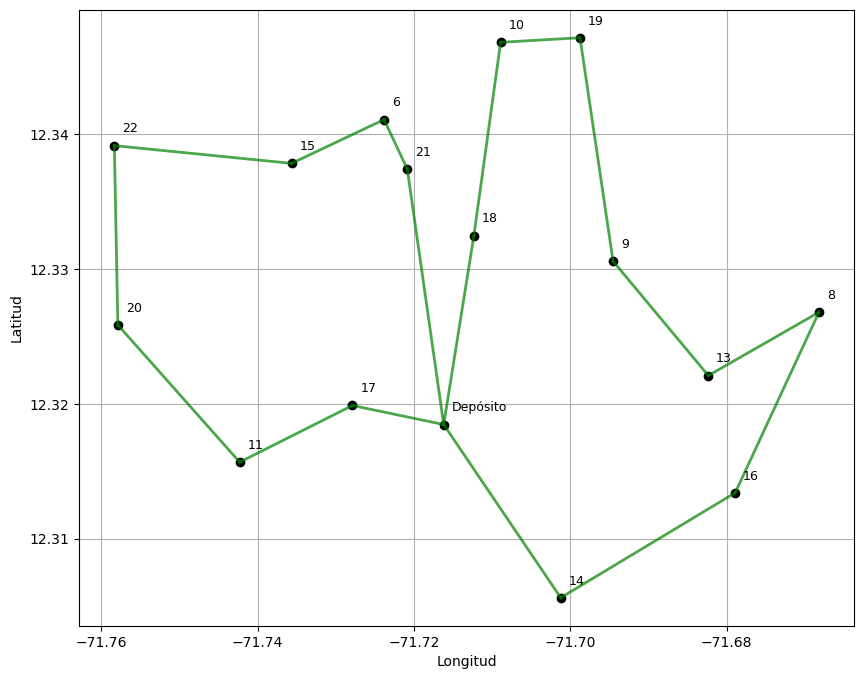

__________________________________________________________________________

Vehículo 1: Carga al pasar por el nodo 21 = 166.00
Demanda del nodo 21 = 34.0
Vehículo 1: Carga al pasar por el nodo 18 = 188.00
Demanda del nodo 18 = 12.0
Vehículo 1: Carga al pasar por el nodo 15 = 132.00
Demanda del nodo 15 = 9.0
Vehículo 1: Carga al pasar por el nodo 16 = 100.00
Demanda del nodo 16 = 10.0
Vehículo 1: Carga al pasar por el nodo 13 = 128.00
Demanda del nodo 13 = 10.0
Vehículo 1: Carga al pasar por el nodo 19 = 160.00
Demanda del nodo 19 = 15.0
Vehículo 1: Carga al pasar por el nodo 17 = 42.00
Demanda del nodo 17 = 24.0
Vehículo 1: Carga al pasar por el nodo 8 = 110.00
Demanda del nodo 8 = 18.0
Vehículo 1: Carga al pasar por el nodo 5 = 200.00
Demanda del nodo 5 = 0.0
Vehículo 1: Carga al pasar por el nodo 22 = 100.00
Demanda del nodo 22 = 32.0
Vehículo 1: Carga al pasar por el nodo 14 = 91.00
Demanda del nodo 14 = 9.0
Vehículo 1: Carga al pasar por el nodo 3 = 200.00
Demanda del nodo 3 = 0.0


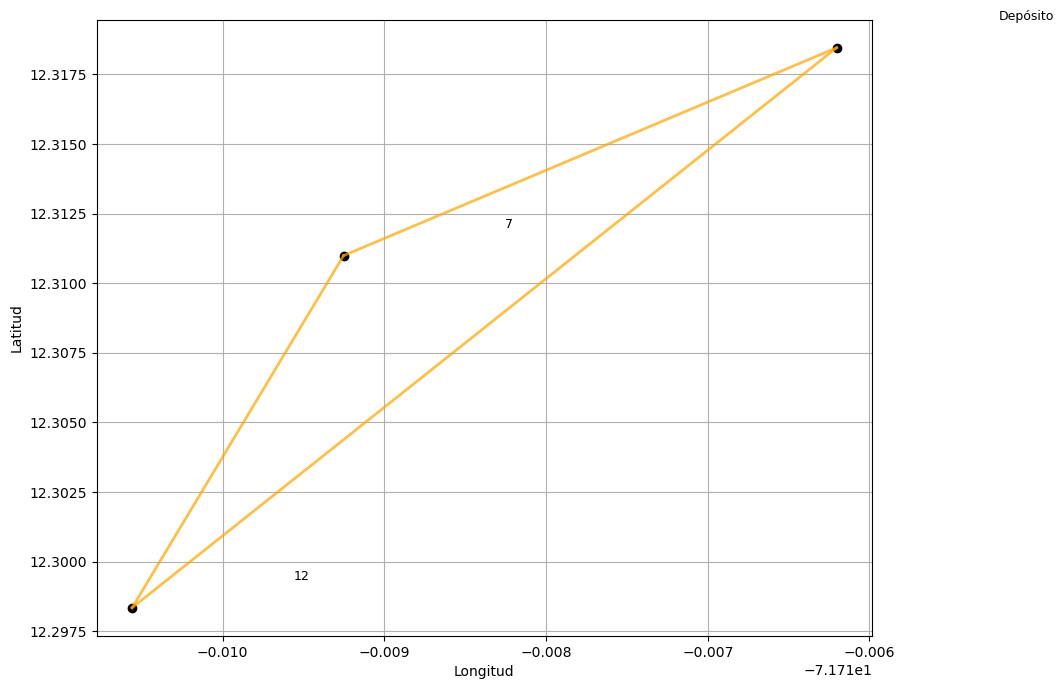

__________________________________________________________________________

Vehículo 1: Carga al pasar por el nodo 21 = 166.00
Demanda del nodo 21 = 34.0
Vehículo 1: Carga al pasar por el nodo 18 = 188.00
Demanda del nodo 18 = 12.0
Vehículo 1: Carga al pasar por el nodo 15 = 132.00
Demanda del nodo 15 = 9.0
Vehículo 1: Carga al pasar por el nodo 16 = 100.00
Demanda del nodo 16 = 10.0
Vehículo 1: Carga al pasar por el nodo 13 = 128.00
Demanda del nodo 13 = 10.0
Vehículo 1: Carga al pasar por el nodo 19 = 160.00
Demanda del nodo 19 = 15.0
Vehículo 1: Carga al pasar por el nodo 17 = 42.00
Demanda del nodo 17 = 24.0
Vehículo 1: Carga al pasar por el nodo 8 = 110.00
Demanda del nodo 8 = 18.0
Vehículo 1: Carga al pasar por el nodo 5 = 200.00
Demanda del nodo 5 = 0.0
Vehículo 1: Carga al pasar por el nodo 22 = 100.00
Demanda del nodo 22 = 32.0
Vehículo 1: Carga al pasar por el nodo 14 = 91.00
Demanda del nodo 14 = 9.0
Vehículo 1: Carga al pasar por el nodo 3 = 200.00
Demanda del nodo 3 = 0.0


In [23]:
from amplpy import modules
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import random
import math

# Resolver el modelo con Gurobi
solver = SolverFactory('gurobi')
results = solver.solve(
    model,
    tee=True,
    options={
        'TimeLimit': 300,
        'MIPGap': 0.01,
        'Threads': 4,
        'Presolve': 2,
        'Cuts': 2,
        'Heuristics': 0.5
    }
)

model.display()

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'cyan', 'magenta', 'olive', 'black']


# Nodo representativo para los depósitos (0 a 5)
depot_nodes = set(range(6))
representative_depot = 0

# Inicializar rutas
routes = {k: [] for k in model.V}

# Recorrer las rutas encontradas en el modelo
for k in model.V:
    for i in model.N:
        for j in model.N:
            if i != j and pyo.value(model.x[i, j, k]) > 0.5:
                # Reemplazar nodos del depósito por el representativo
                i_rep = representative_depot if i in depot_nodes else i
                j_rep = representative_depot if j in depot_nodes else j
                if (i_rep, j_rep) not in routes[k]:  # evitar duplicados
                    routes[k].append((i_rep, j_rep))

# Función para calcular y mostrar el costo de cada ruta
for k in model.V:
    edges = routes[k]
    if not edges:
        continue

    used_nodes_k = set()
    for i, j in edges:
        used_nodes_k.add(i)
        used_nodes_k.add(j)

    total_cost_k = 0
    for (i, j) in edges:
        # Usar el original para el costo (no el representativo)
        cost = pyo.value(model.cost[i, j, k]) if (i, j) in model.cost else 0
        total_cost_k += cost
        print(f"Vehículo {k}: Costo de la ruta de {i} a {j} = {cost:.2f}")

    print(f"Vehículo {k}: Costo total del recorrido = {total_cost_k:.2f}\n")

    # Graficar nodos y rutas
    coords_k = {i: lat_lon_list[i] for i in used_nodes_k}
    
    # Asegurarse de que el nodo representativo tenga coordenadas (usar las del nodo 0)
    if representative_depot not in coords_k:
        coords_k[representative_depot] = lat_lon_list[representative_depot]

    plt.figure(figsize=(10, 8))

    # Dibujar nodos
    for i, (lat, lon) in coords_k.items():
        plt.plot(lon, lat, 'ko')
        label = "Depósito" if i == representative_depot else str(i)
        plt.text(lon + 0.001, lat + 0.001, label, fontsize=9)

    # Dibujar ruta del vehículo
    color = colors[k % len(colors)]
    for (i, j) in edges:
        lat1, lon1 = coords_k[i]
        lat2, lon2 = coords_k[j]
        plt.plot([lon1, lon2], [lat1, lat2], color=color, linewidth=2, alpha=0.7)

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True)
    plt.show()
    
    # print("Demanda de cada cliente:")
    # for j in model.C:
    #     demanda = pyo.value(model.De[j])
    #     print(f"Cliente {j}: demanda = {demanda}")
        
    #for cargas 
    
    # for i in model.N:
    #     carga = pyo.value(model.W[i, 2])
    #     if carga > 0:
    #         print(f"Vehículo 2: Carga en nodo {i} = {carga:.2f}")
            
    # si pasa al nodo mostrar a carg qe lleva
    

    print("__________________________________________________________________________\n")
    for k in model.V:
        for i in model.N:
            for j in model.N:
                if i != j and pyo.value(model.x[i, j, k]) > 0.5:
                    carga = pyo.value(model.W[j, k])
                    print(f"Vehículo {k}: Carga al pasar por el nodo {j} = {carga:.2f}")
                    print(f"Demanda del nodo {j} = {model.De[j]}")
        print("__________________________________________________________________________\n")
            
                


In [64]:
from collections import defaultdict
from datetime import datetime
from datetime import timedelta

hora_inicio_base = datetime.strptime("08:00", "%H:%M")




def build_visit_path(arcs):
    graph = defaultdict(list)
    for u, v in arcs:
        graph[u].append(v)

    full_path = []
    used_edges = set()

    def dfs(node):
        while graph[node]:
            next_node = graph[node].pop(0)
            edge = (node, next_node)
            if edge not in used_edges:
                used_edges.add(edge)
                dfs(next_node)
        if node == 0:    
            full_path.append(node)
        else:
            full_path.append(node-5)

    # Hay múltiples rutas que comienzan desde 0
    starts = [v for u, v in arcs if u == 0]
    for start in starts:
        if (0, start) not in used_edges:
            dfs(0)

    return full_path[::-1]  # reverse to get correct order

ordered_routes = {}

for vehicle, arcs in routes.items():
    ordered_routes[vehicle] = build_visit_path(arcs) if arcs else []

# Mostrar resultado
for v, path in ordered_routes.items():
    print(f"Vehículo {v}: {path}")

# Costo total por vehículo
costos_por_vehiculo = {}
distancias_por_vehiculo = {}
id_vehiculo = {}
tipo_vehiculo = {}
init_load = {}
clients = {}
arrival_times = {}


for k in model.V:
    costo_k = sum(
        model.cost[i, j, k] * model.x[i, j, k].value
        for i in model.N
        for j in model.N
        if i != j and model.x[i, j, k].value is not None and model.x[i, j, k].value > 0.5
    )
    costos_por_vehiculo[k] = costo_k

# Mostrar los resultados
for k in model.V:
    print(f"Vehículo {k}: Costo total de ruta = {costos_por_vehiculo[k]:.2f}")

for k in model.V:
    tipo_k = model.tipo[k]
    distancias_por_vehiculo[k] = costos_por_vehiculo[k] / costos[tipo_k]
    print(f"Vehículo {k}: Distancia total recorrida = {distancias_por_vehiculo[k]:.2f} km")

for k in model.V:
    if model.tipo[k] == 0:
        id_vehiculo[k] = "TRK00"+ str(k)
    else:
        id_vehiculo[k] = "DRN00"+ str(k)
print(id_vehiculo)

for k in model.V:
    tipo_k = model.tipo[k]
    tipo_vehiculo[k] = "Truck" if tipo_k == 0 else "Drone"
    print(f"Vehículo {k}: Tipo = {tipo_vehiculo[k]}")

for k in model.V:
    # si el largo de la ruta del vehiculo es 0, la carga inicial es 0
    if not ordered_routes[k]:
        init_load[k] = 0
        print(f"Vehículo {k}: Carga inicial = {init_load[k]} kg ")
    else:
        # La carga inicial es la capacidad del vehículo
        init_load[k] = model.P[k]
        print(f"Vehículo {k}: Carga inicial = {init_load[k]} kg")

for k in model.V:
    #cantidad de clientes visitados por el vehiculo
    clients[k] = sum(
        1 for i in model.N if i in model.C and any(model.x[i, j, k].value > 0.5 for j in model.N if i != j)
    )
    print(f"Vehículo {k}: Clientes visitados = {clients[k]}")
# Demanda por cliente visitado y total por vehículo
demanda_por_cliente = {}
demanda_total_por_vehiculo = {}
num_resuplimientos = {}
cantidad_resuplida = {}
tiempo_por_vehiculo = {}

for k in model.V:
    demanda_vehiculo = []
    total_demanda = 0

    for nodo in ordered_routes[k]:
        if nodo !=0:
            demanda_nodo = model.De[nodo+5]
            demanda_vehiculo.append((nodo, demanda_nodo))
            total_demanda += demanda_nodo

    demanda_por_cliente[k] = demanda_vehiculo
    demanda_total_por_vehiculo[k] = total_demanda

# Mostrar resultados
for k in model.V:
    print(f"\nVehículo {k} atendió los siguientes clientes con sus demandas:")
    for cliente, demanda in demanda_por_cliente[k]:
        print(f"  Cliente {cliente}: {demanda} kg")
    print(f"  → Demanda total servida por vehículo {k}: {demanda_total_por_vehiculo[k]} kg")

# Tiempos de llegada a cada cliente
for k in model.V:
    arrival_times[k] = []
    tiempo_agregado = 10
    tiempo_inicial = datetime.strptime("08:00", "%H:%M")
    for nodo in ordered_routes[k]:
        if nodo != 0:  # Excluir el depósito
            arrival_times[k].append(tiempo_inicial.strftime("%H:%M"))
            tiempo_inicial += timedelta(minutes=tiempo_agregado)
for k in model.V:
    print(f"\nVehículo {k} llegó a los clientes en los siguientes tiempos:")
    for idx, hora in enumerate(arrival_times[k]):
        print(f"  Cliente {ordered_routes[k][idx]} → {hora}")

for k in model.V:
    #numero de resuplimientos por vehículo
    if not ordered_routes[k]:
        num_resuplimientos[k] = 0
    else:
        num_resuplimientos[k] = sum(
            1 for i in ordered_routes[k] if i == 0
        ) -2
    print(f"Vehículo {k}: Número de resuplimientos = {num_resuplimientos[k]}")

for k in model.V:
    num_suplimientos = num_resuplimientos[k]
    if num_suplimientos > 0:
        cantidad_resuplida[k] = model.P[k] * num_suplimientos
    else:
        cantidad_resuplida[k] = 0
    print(f"Vehículo {k}: Cantidad resuplida = {cantidad_resuplida[k]} kg")

# Calcular el tiempo total de recorrido por vehículo
for k in model.V:
    if not ordered_routes[k]:
        tiempo_total = 0
    else:
        tiempo_total = len(ordered_routes[k]) * 10  # 10 minutos por cliente
    tiempo_por_vehiculo[k] = tiempo_total
    print(f"Vehículo {k}: Tiempo total de recorrido = {tiempo_por_vehiculo[k]} minutos")
    
    


Vehículo 1: [0, 16, 1, 10, 17, 15, 6, 12, 0, 13, 5, 14, 4, 8, 3, 11, 9, 0]
Vehículo 2: []
Vehículo 3: [0, 2, 7, 0]
Vehículo 1: Costo total de ruta = 21.52
Vehículo 2: Costo total de ruta = 0.00
Vehículo 3: Costo total de ruta = 1.07
Vehículo 1: Distancia total recorrida = 37.75 km
Vehículo 2: Distancia total recorrida = 0.00 km
Vehículo 3: Distancia total recorrida = 4.59 km
{1: 'TRK001', 2: 'DRN002', 3: 'DRN003'}
Vehículo 1: Tipo = Truck
Vehículo 2: Tipo = Drone
Vehículo 3: Tipo = Drone
Vehículo 1: Carga inicial = 200.0 kg
Vehículo 2: Carga inicial = 0 kg 
Vehículo 3: Carga inicial = 25.0 kg
Vehículo 1: Clientes visitados = 15
Vehículo 2: Clientes visitados = 0
Vehículo 3: Clientes visitados = 2

Vehículo 1 atendió los siguientes clientes con sus demandas:
  Cliente 16: 34.0 kg
  Cliente 1: 25.0 kg
  Cliente 10: 9.0 kg
  Cliente 17: 32.0 kg
  Cliente 15: 30.0 kg
  Cliente 6: 4.0 kg
  Cliente 12: 24.0 kg
  Cliente 13: 12.0 kg
  Cliente 5: 13.0 kg
  Cliente 14: 15.0 kg
  Cliente 4: 22.0

In [65]:
import csv

with open("datos/caso_3/verificacion_caso3.csv", mode="w", newline="") as file:
    writer = csv.writer(file)

    # Escribir encabezado
    writer.writerow([
        "VehicleId", "VehicleType", "InitLoad", "RouteSequence", "Clients",
        "DemandSatisfied", "ArrivalTimes", "Resup", "ResupAmounts", 
        "Distance", "Time", "Cost"
    ])

    for k in model.V:
        # ID y tipo
        vehicle_id = id_vehiculo[k]
        vehicle_type = tipo_vehiculo[k]
        init = init_load[k]

        # Ruta: convertir nodos a COM## y CD
        ruta = []
        for nodo in ordered_routes[k]:
            if nodo == 0:
                ruta.append("CD")
            else:
                ruta.append(f"COM{nodo:02d}")
        ruta_str = " - ".join(ruta)

        # Clientes y demanda
        num_clientes = clients[k]
        demanda_str = " - ".join(str(d) for _, d in demanda_por_cliente[k]) if demanda_por_cliente[k] else ""

        # Tiempos de llegada
        tiempos = " - ".join(arrival_times[k]) if arrival_times[k] else ""

        # Resuplimientos, distancias, tiempo y costo
        resup = num_resuplimientos[k]
        resup_amount = cantidad_resuplida[k]
        dist = round(distancias_por_vehiculo[k], 1)
        tiempo = tiempo_por_vehiculo[k]
        costo = round(costos_por_vehiculo[k], 1)

        # Escribir fila
        writer.writerow([
            vehicle_id, vehicle_type, init, ruta_str, num_clientes,
            demanda_str, tiempos, resup, resup_amount, dist, tiempo, costo
        ])
